In [44]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM==4.3.0
!pip list | grep lightgbm

lightgbm                     4.3.0


In [45]:
import pandas as pd
import seaborn as sns

import numpy as np
# CSVファイルを読み込む
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
genre_data = pd.read_csv('input/genre_labels.csv')
print("train_data;",len(train))
print("test_data;",len(test))

train_data; 4046
test_data; 4046


In [46]:
# データの可視化
train.describe()

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness
count,4046.000000,4046.000000,4046.000000,4.046000e+03,4046.000000,4036.000000,4038.000000,4046.000000,4046.000000,4043.000000,4038.000000,4045.000000
mean,2022.500000,7.281760,41.056105,2.421410e+05,0.346455,0.464100,0.504347,-7.715659,0.603663,0.265986,0.198655,0.214336
std,1168.123923,2.887542,16.165708,8.520241e+04,0.241004,0.225052,0.158415,4.109640,0.201020,0.155769,0.083557,0.154281
min,0.000000,0.000000,0.000000,5.998000e+03,0.000000,0.000000,0.013839,-37.820457,0.003383,0.000000,0.000000,0.000000
25%,1011.250000,7.000000,31.000000,2.044420e+05,0.149705,0.276384,0.392581,-9.775363,0.462137,0.168527,0.148698,0.143295
50%,2022.500000,8.000000,42.000000,2.358735e+05,0.250711,0.450211,0.510993,-7.189460,0.634078,0.218486,0.183190,0.171708
75%,3033.750000,10.000000,52.000000,2.724020e+05,0.523088,0.644786,0.617371,-4.876553,0.768768,0.317773,0.224999,0.205446
max,4045.000000,10.000000,82.000000,2.135773e+06,1.000000,0.989661,1.000000,0.000000,1.000000,1.000000,0.886806,1.000000


In [47]:
train.isnull().sum()

# Nullを埋め込み（testデータは何かしらで補完しないといけないのでtrainも同様に補完する）



index                0
genre                0
popularity           0
duration_ms          0
acousticness         0
positiveness        10
danceability         8
loudness             0
energy               0
liveness             3
speechiness          8
instrumentalness     1
tempo                0
region               0
dtype: int64

In [48]:
# とりあえず線形補完。上端はそのままになるので注意
# train.replace(['NaN', 'None', ''], float('nan'))
train = train.interpolate()

In [49]:
test.describe()

,index,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness
count,4046.000000,4046.000000,4.046000e+03,4045.000000,4032.000000,4035.000000,4046.000000,4045.000000,4040.000000,4035.000000,4044.000000
mean,6068.500000,41.158181,2.418486e+05,0.335216,0.467855,0.499143,-7.636531,0.608755,0.268926,0.201776,0.216227
std,1168.123923,16.107248,7.829733e+04,0.236284,0.220606,0.161413,3.989469,0.200665,0.157032,0.086553,0.156315
min,4046.000000,0.000000,5.826000e+03,0.012727,0.014537,0.000000,-30.216122,0.000000,0.017454,0.016510,0.045321
25%,5057.250000,31.000000,2.019200e+05,0.145535,0.288579,0.388765,-9.768664,0.461840,0.168854,0.149764,0.144141
50%,6068.500000,42.000000,2.353070e+05,0.245121,0.446927,0.508350,-7.088928,0.636469,0.220989,0.186697,0.172429
75%,7079.750000,52.000000,2.724925e+05,0.494312,0.641742,0.616642,-4.936082,0.774140,0.323248,0.229745,0.205682
max,8091.000000,82.000000,1.105001e+06,0.985922,1.000000,0.948866,0.000000,0.991536,0.997364,1.000000,0.927823


In [50]:
test.isnull().sum()

index                0
popularity           0
duration_ms          0
acousticness         1
positiveness        14
danceability        11
loudness             0
energy               1
liveness             6
speechiness         11
instrumentalness     2
tempo                0
region               0
dtype: int64

In [51]:
# とりあえず線形補完。上端はそのままになるので注意
test = test.interpolate()


In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4046 non-null   int64  
 1   genre             4046 non-null   int64  
 2   popularity        4046 non-null   int64  
 3   duration_ms       4046 non-null   int64  
 4   acousticness      4046 non-null   float64
 5   positiveness      4046 non-null   float64
 6   danceability      4046 non-null   float64
 7   loudness          4046 non-null   float64
 8   energy            4046 non-null   float64
 9   liveness          4046 non-null   float64
 10  speechiness       4046 non-null   float64
 11  instrumentalness  4046 non-null   float64
 12  tempo             4046 non-null   object 
 13  region            4046 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 442.7+ KB


In [53]:
# カテゴリ変数と質量変数に分類(genreは目的変数なので対象外)
categorical = ["region"]
target_col = ["genre"]
genre_data


,genre,labels
0,country,0
1,electronic,1
2,folk,2
3,hip-hop,3
4,jazz,4
5,latin,5
6,classic,6
7,other-light-music,7
8,pop,8
9,religious,9


Text(0, 0.5, 'Frequency')

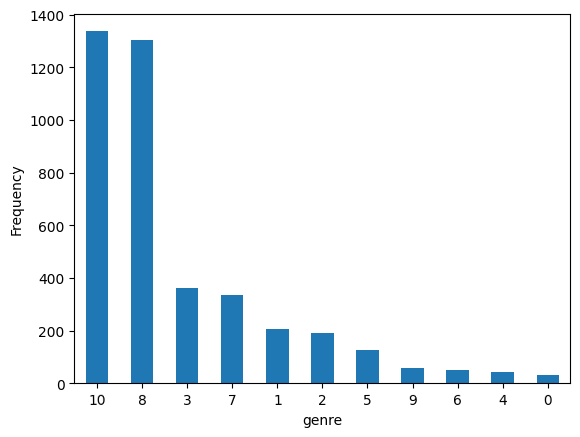

In [54]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 10

count_classes = pd.value_counts(train['genre'], sort = True)
count_classes.plot(kind = 'bar', rot=1)
plt.xlabel("genre")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

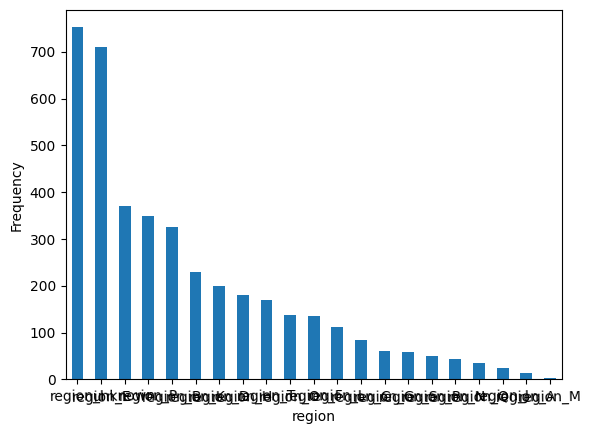

In [55]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 10

count_classes = pd.value_counts(train['region'], sort = True)
count_classes.plot(kind = 'bar', rot=1)
plt.xlabel("region")
plt.ylabel("Frequency")


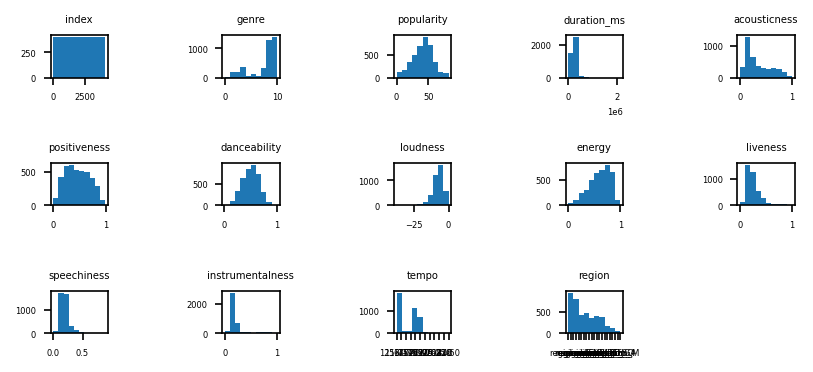

In [56]:
fig = plt.figure(dpi=150)
for i, col in enumerate(train.columns):
    plt.rcParams["font.size"] = 4
    plt.subplots_adjust(wspace=2, hspace=2)
    # plt.figure(figsize=(4, 4))
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(train[col])
    plt.title(col)


In [57]:
train.columns

Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo', 'region'],
      dtype='object')

In [58]:
exec_flag=False
#　処理に時間がかかるので見たい時だけTrueにしてください
if exec_flag:
    sns.pairplot(data=train[["genre","popularity", "duration_ms", "acousticness", "positiveness", "danceability", "loudness",
                              "energy", "liveness", "speechiness", "instrumentalness", "tempo", "region"]], hue="genre", dropna=True)

In [59]:
# tempoとregionをintに変換する。
# from sklearn.preprocessing import LabelEncoder
label = ["region","tempo"]
for col in label:
    encoder = {c: i for i, c in enumerate(train[col].unique())}
    train[f'label_{col}'] = train[col].map(encoder)
    test[f'label_{col}'] = test[col].map(encoder)

# regionをワンホットベクトルか
one_hot_vector = True
if one_hot_vector:
    train['label_region'] = train['label_region'].astype(str)
    train['label_tempo'] = train['label_tempo'].astype(str)
    test['label_region'] = test['label_region'].astype(str)
    test['label_tempo'] = test['label_tempo'].astype(str)
    df_one_hot_encoded_train = pd.get_dummies(train,dtype=int)
    df_one_hot_encoded_test = pd.get_dummies(test, dtype=int)
    print(df_one_hot_encoded_train)
    train = pd.merge(train,df_one_hot_encoded_train)
    test = pd.merge(test,df_one_hot_encoded_test)


      index  genre  popularity  duration_ms  acousticness  positiveness   
0         0     10          11       201094      0.112811      0.157247  \
1         1      8          69       308493      0.101333      0.346563   
2         2      3          43       197225      0.496420      0.265391   
3         3     10          45       301092      0.165667      0.245533   
4         4      3          57       277348      0.190720      0.777578   
...     ...    ...         ...          ...           ...           ...   
4041   4041     10          38       246309      0.128795      0.329718   
4042   4042      5          23       208734      0.778732      0.228757   
4043   4043     10          30       407016      0.402050      0.462374   
4044   4044     10          25       204957      0.208096      0.465511   
4045   4045      3          38       185527      0.213589      0.945140   

      danceability   loudness    energy  liveness  ...  label_tempo_10   
0         0.187841  -1.88

In [60]:
# tempoはtempoの幅を新たな特長量として取得する。
train_tempo_low = train["tempo"].str.extract('(.+)-', expand=True)
train_tempo_high = train["tempo"].str.extract('-(.+)', expand=True)

test_tempo_low = test["tempo"].str.extract('(.+)-', expand=True)
test_tempo_high = test["tempo"].str.extract('-(.+)', expand=True)


In [61]:
train_tempo_low = train_tempo_low.astype(int)
train_tempo_high = train_tempo_high.astype(int)
train["tempo_range"] = train_tempo_high[0] - train_tempo_low[0]
train["tempo_low"] = train_tempo_low
train["tempo_high"] = train_tempo_high
train.describe()

test_tempo_low = test_tempo_low.astype(int)
test_tempo_high = test_tempo_high.astype(int)
test["tempo_range"] = test_tempo_high[0] - test_tempo_low[0]
test["tempo_low"] = test_tempo_low
test["tempo_high"] = test_tempo_high
test.describe()

,index,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,...,label_tempo_3,label_tempo_4,label_tempo_5,label_tempo_6,label_tempo_7,label_tempo_8,label_tempo_9,tempo_range,tempo_low,tempo_high
count,4046.000000,4046.000000,4.046000e+03,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,...,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,6068.500000,41.158181,2.418486e+05,0.335188,0.467623,0.498999,-7.636531,0.608751,0.268862,0.201718,...,0.032130,0.279288,0.180672,0.012111,0.003955,0.000247,0.000741,24.207612,109.867029,134.074642
std,1168.123923,16.107248,7.829733e+04,0.236261,0.220419,0.161353,3.989469,0.200640,0.156928,0.086481,...,0.176368,0.448705,0.384794,0.109394,0.062768,0.015721,0.027223,5.719993,29.073576,31.155091
min,4046.000000,0.000000,5.826000e+03,0.012727,0.014537,0.000000,-30.216122,0.000000,0.017454,0.016510,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,40.000000
25%,5057.250000,31.000000,2.019200e+05,0.145570,0.288486,0.388701,-9.768664,0.461895,0.168966,0.149790,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,97.000000,120.000000
50%,6068.500000,42.000000,2.353070e+05,0.245119,0.446824,0.508093,-7.088928,0.636347,0.220989,0.186697,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,97.000000,120.000000
75%,7079.750000,52.000000,2.724925e+05,0.494206,0.641574,0.616498,-4.936082,0.774118,0.323119,0.229689,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,121.000000,152.000000
max,8091.000000,82.000000,1.105001e+06,0.985922,1.000000,0.948866,0.000000,0.991536,0.997364,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.000000,209.000000,220.000000


In [62]:
# regionは変換完了したのでlabelは削除する.共線性回避でhigh,lowを削除
if not one_hot_vector:
    train.drop(["region","tempo","tempo_high","tempo_low"], axis=1, inplace=True)
    test.drop(["region","tempo","tempo_high","tempo_low"], axis=1, inplace=True)
else:
    # ワンホットベクトルするなら以下にする
    train.drop(["region","tempo","tempo_high","tempo_low","label_tempo","label_region"], axis=1, inplace=True)
    test.drop(["region","tempo","tempo_high","tempo_low","label_tempo","label_region"], axis=1, inplace=True)
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 79 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4046 non-null   int64  
 1   genre             4046 non-null   int64  
 2   popularity        4046 non-null   int64  
 3   duration_ms       4046 non-null   int64  
 4   acousticness      4046 non-null   float64
 5   positiveness      4046 non-null   float64
 6   danceability      4046 non-null   float64
 7   loudness          4046 non-null   float64
 8   energy            4046 non-null   float64
 9   liveness          4046 non-null   float64
 10  speechiness       4046 non-null   float64
 11  instrumentalness  4046 non-null   float64
 12  tempo_0-40        4046 non-null   int64  
 13  tempo_121-152     4046 non-null   int64  
 14  tempo_153-176     4046 non-null   int64  
 15  tempo_177-192     4046 non-null   int64  
 16  tempo_193-208     4046 non-null   int64  


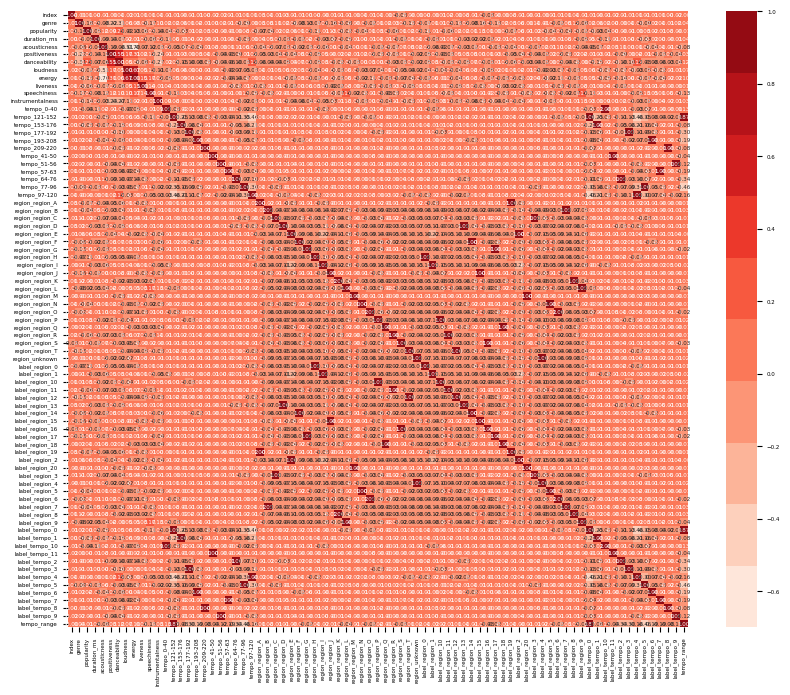

In [63]:
# 情報量が多く処理が完了しないので8月までのデータでヒートマップ算出する
%matplotlib inline
corrs = np.corrcoef(train, rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=train.columns.tolist(), yticklabels=train.columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [64]:
# 対数変換
log_list = ["popularity","duration_ms","acousticness","positiveness","danceability","loudness",
            "energy","liveness","speechiness","instrumentalness"]
# fig = plt.figure(dpi=150)
# for i,indent in enumerate(log_list):
#     plt.rcParams["font.size"] = 4
#     plt.subplots_adjust(wspace=2, hspace=2)
#     train[indent] = np.log(train[indent])
#     test[indent] = np.log(test[indent])
#     plt.subplot2grid((5, 5), (i//5 ,i%5))
#     plt.hist(train[indent])
#     plt.title(indent)
# train.describe()

In [65]:
##特徴選択
!pip install imblearn

In [66]:
# # ②不均衡データへの処置
# # アンダーサンプリング
# from imblearn.under_sampling import RandomUnderSampler

# target = 'target'
# rs = RandomUnderSampler(random_state=42)
# under_sampling ,_ = rs.fit_resample(train, train[target])

# print('*'*20)
# print('＜元のデータ＞')
# print('0の件数：%d'%len(train.query(f'{target}==0')))
# print('1の件数：%d'%len(train.query(f'{target}==1')))
# print('*'*20)
# print('＜アンダーサンプリング後のデータ＞')
# print('0の件数：%d'%len(under_sampling.query(f'{target}==0')))
# print('1の件数：%d'%len(under_sampling.query(f'{target}==1')));

# train = under_sampling.copy()


In [67]:
# 学習データと結果に分割
# 正常データを異常データと同数にして学習
# train_total = under_sampling.copy()
y = train['genre']
train.drop('genre', axis=1, inplace=True)
# idは削除
train.drop('index', axis=1, inplace=True)
#多重共線性の観点から位置を省いてみる
# train_total = train.drop(['x_customer_id',"y_customer_id"], axis=1) #'count' 列を削除

test_id = test["index"]
test.drop('index', axis=1, inplace=True)
test_total = test.copy()
# test_total = test.drop(['x_customer_id',"y_customer_id"], axis=1) #'count' 列を削除


In [68]:
#量的変数の定義
# agg_cols = ['min', 'max', 'mean', 'std']
# カテゴリカル変数の定義
# cat_cols = ['anaemia', 'dカテゴリカルiabetes', 'high_blood_pressure','sex',"smoking"]

In [69]:
# カテゴリカル変数と量的変数を組み合わせて新たな特長量を生成する。今回はカテゴリカル変数は少ないので省略

# for col in cat_cols:
#     grp_df = train.groupby(col)[log_list].agg(agg_cols)
#     grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
#     train = train.merge(grp_df, on=col, how='left')
#     test_total = test_total.merge(grp_df, on=col, how='left')    

In [70]:
!pip install -U "setuptools<58"
!pip install xfeat

In [71]:
# カテゴリ変数の組み合わせで新たな特長量を生成する。今回はカテゴリかる変数が少ないのでコメントアウト

# import xfeat

# for i in [2, 3]:
#     print(i)
#     concat = xfeat.ConcatCombination(r=i, drop_origin=True)
#     train = pd.concat([train, concat.fit_transform(train[cat_cols])], axis=1)
#     test_total = pd.concat([test_total, concat.fit_transform(test[cat_cols])], axis=1)

In [72]:
# 量的変数の標準化。SVCやMLPに刺さる。
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[log_list])
train[log_list] = scaler.transform(train[log_list])
test_total[log_list] = scaler.transform(test_total[log_list])

In [73]:
# データフレーム同士のカラム名の差分を取得・比較する方法
# trainにあって、testにないものを表示する
column_diffs = list(filter(lambda x: x not in test_total.columns, train.columns))
print(column_diffs)
# testにあって、trainにないものを表示する
print(list(filter(lambda x: x not in train.columns,  test_total.columns)))

# testとtrainの系列を合わせる必要があるのでtestに追加する。
for column_diff in column_diffs:
    print(column_diff)
    print(train[column_diff])
    test_total[column_diff] = 0
test_total.describe()

# 順番を統一させるためにソートする
train=train.sort_index(axis=1) 
test_total=test_total.sort_index(axis=1) 


['region_region_M', 'label_region_20']
[]
region_region_M
0       0
1       0
2       0
3       0
4       0
       ..
4041    0
4042    0
4043    0
4044    0
4045    0
Name: region_region_M, Length: 4046, dtype: int64
label_region_20
0       0
1       0
2       0
3       0
4       0
       ..
4041    0
4042    0
4043    0
4044    0
4045    0
Name: label_region_20, Length: 4046, dtype: int64


In [74]:
train.describe()


,acousticness,danceability,duration_ms,energy,instrumentalness,label_region_0,label_region_1,label_region_10,label_region_11,label_region_12,...,tempo_177-192,tempo_193-208,tempo_209-220,tempo_41-50,tempo_51-56,tempo_57-63,tempo_64-76,tempo_77-96,tempo_97-120,tempo_range
count,4.046000e+03,4.046000e+03,4.046000e+03,4.046000e+03,4.046000e+03,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,...,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,-1.764942e-16,1.343463e-16,-7.375876e-17,3.582568e-16,-1.580545e-16,0.044736,0.185863,0.086258,0.012358,0.042017,...,0.031389,0.012852,0.000989,0.000247,0.001236,0.003213,0.023233,0.185615,0.285961,24.391498
std,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,0.206748,0.389044,0.280779,0.110491,0.200652,...,0.174388,0.112651,0.031431,0.015721,0.035136,0.056600,0.150661,0.388844,0.451927,5.588304
min,-1.437725e+00,-3.097879e+00,-2.771896e+00,-2.986532e+00,-1.389493e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,-8.164788e-01,-7.055045e-01,-4.425190e-01,-7.041246e-01,-4.604635e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
50%,-3.973193e-01,4.427546e-02,-7.356956e-02,1.513238e-01,-2.764980e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000
75%,7.329958e-01,7.124917e-01,3.552096e-01,8.214366e-01,-5.755030e-02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,31.000000
max,2.712093e+00,3.131343e+00,2.222785e+01,1.971869e+00,5.093684e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.000000


In [75]:
# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.3, random_state=42)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      4046 non-null   float64
 1   danceability      4046 non-null   float64
 2   duration_ms       4046 non-null   float64
 3   energy            4046 non-null   float64
 4   instrumentalness  4046 non-null   float64
 5   label_region_0    4046 non-null   int64  
 6   label_region_1    4046 non-null   int64  
 7   label_region_10   4046 non-null   int64  
 8   label_region_11   4046 non-null   int64  
 9   label_region_12   4046 non-null   int64  
 10  label_region_13   4046 non-null   int64  
 11  label_region_14   4046 non-null   int64  
 12  label_region_15   4046 non-null   int64  
 13  label_region_16   4046 non-null   int64  
 14  label_region_17   4046 non-null   int64  
 15  label_region_18   4046 non-null   int64  
 16  label_region_19   4046 non-null   int64  


In [76]:
test_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      4046 non-null   float64
 1   danceability      4046 non-null   float64
 2   duration_ms       4046 non-null   float64
 3   energy            4046 non-null   float64
 4   instrumentalness  4046 non-null   float64
 5   label_region_0    4046 non-null   int64  
 6   label_region_1    4046 non-null   int64  
 7   label_region_10   4046 non-null   int64  
 8   label_region_11   4046 non-null   int64  
 9   label_region_12   4046 non-null   int64  
 10  label_region_13   4046 non-null   int64  
 11  label_region_14   4046 non-null   int64  
 12  label_region_15   4046 non-null   int64  
 13  label_region_16   4046 non-null   int64  
 14  label_region_17   4046 non-null   int64  
 15  label_region_18   4046 non-null   int64  
 16  label_region_19   4046 non-null   int64  


In [77]:
# 性能的にLightGBM > RandomForestなのでコメントアウトで時短

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score
# from tqdm import tqdm
# #条件設定
# max_score = 0
# SearchMethod = 0
# RFC_grid = {RandomForestClassifier(): {"n_estimators":[i for i in range(1, 100,10)],
#                                        "criterion": ["entropy"],
#                                        "max_depth":[15,20,25],
#                                        "min_samples_split":[1,3],
#                                        "min_samples_leaf":[1,3, 5],
#                                       }}
# # RFC_grid = {RandomForestClassifier(): {"n_estimators": [i for i in range(1, 21)],
# #                                        "criterion": ["gini", "entropy"],
# #                                        "max_depth":[i for i in range(1, 5)],
# #                                        "random_state": [i for i in range(0, 101)]
# #                                       }}
# #ランダムフォレストの実行
# for model, param in tqdm(RFC_grid.items()):
#     clf = GridSearchCV(model, param)
#     clf.fit(X_train, y_train)
#     y_pred_train_rf = clf.predict(X_valid)
#     score = f1_score(y_valid, y_pred_train_rf, average="micro")

#     if max_score < score:
#         max_score = score
#         best_param = clf.best_params_
#         best_model = model.__class__.__name__

# print("ベストスコア:{}".format(max_score))
# print("モデル:{}".format(best_model))
# print("パラメーター:{}".format(best_param))

In [78]:
genre_data["genre"]
# y_pred_train_rf

0               country
1            electronic
2                  folk
3               hip-hop
4                  jazz
5                 latin
6               classic
7     other-light-music
8                   pop
9             religious
10                 rock
Name: genre, dtype: object

In [79]:
# import os
# import datetime
# from sklearn import metrics

# Dicision_threshould = 0.5

# path = "result/" 
# now = datetime.datetime.now()
# filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "RandomForest"+ "_" + str(Dicision_threshould)+ '.png'


# if not os.path.isdir(path):
#    os.mkdir(path)


# # スコア(RMSE)算出
# # y_pred_int = np.where(y_pred_train_rf > Dicision_threshould, 1, 0)
# y_pred_int = y_pred_train_rf

# f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")

# print(f'f1_score={f1_score}')
# plt.rcParams["font.size"] = 12

# import seaborn as sns
# from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
#    roc_curve, recall_score, classification_report, f1_score,
#    precision_recall_fscore_support)
# conf_matrix = confusion_matrix(y_valid, y_pred_int)
# plt.figure(figsize=(5, 5))
# sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.savefig(filename)
# plt.show()


One-versus-the-rest: 0.53542
ganmma: 0.1, C: 0.1
One-versus-one: 0.49671
ganmma: 0.1, C: 0.1


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.53542
ganmma: 0.1, C: 0.1


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.56507
ganmma: 0.1, C: 0.1
One-versus-the-rest: 0.44811
One-versus-one: 0.32043


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.44811


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.56260
One-versus-the-rest: 0.32043
One-versus-one: 0.32043


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.32043


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.56343
One-versus-the-rest: 0.57414
ganmma: 0.1, C: 1
One-versus-one: 0.56919
ganmma: 0.1, C: 1


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.57414


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.54860
One-versus-the-rest: 0.44152
One-versus-one: 0.41104


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.44152


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.55848
One-versus-the-rest: 0.32043
One-versus-one: 0.32043


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.32043


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.55848
One-versus-the-rest: 0.55354
One-versus-one: 0.56260


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.55354


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.09473
One-versus-the-rest: 0.44893
One-versus-one: 0.42422


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.44893


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.39703
One-versus-the-rest: 0.32125
One-versus-one: 0.32043


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to 

One-versus-the-rest: 0.32125


/home/hayato/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


One-versus-one: 0.47858
one_rest_f1_final: 0.5741350906095551
normal_f1_final: 0.5691927512355849
one_rest_f1_linear_final: 0.5642504118616145
normal_f1_linear_final: 0.5650741350906096


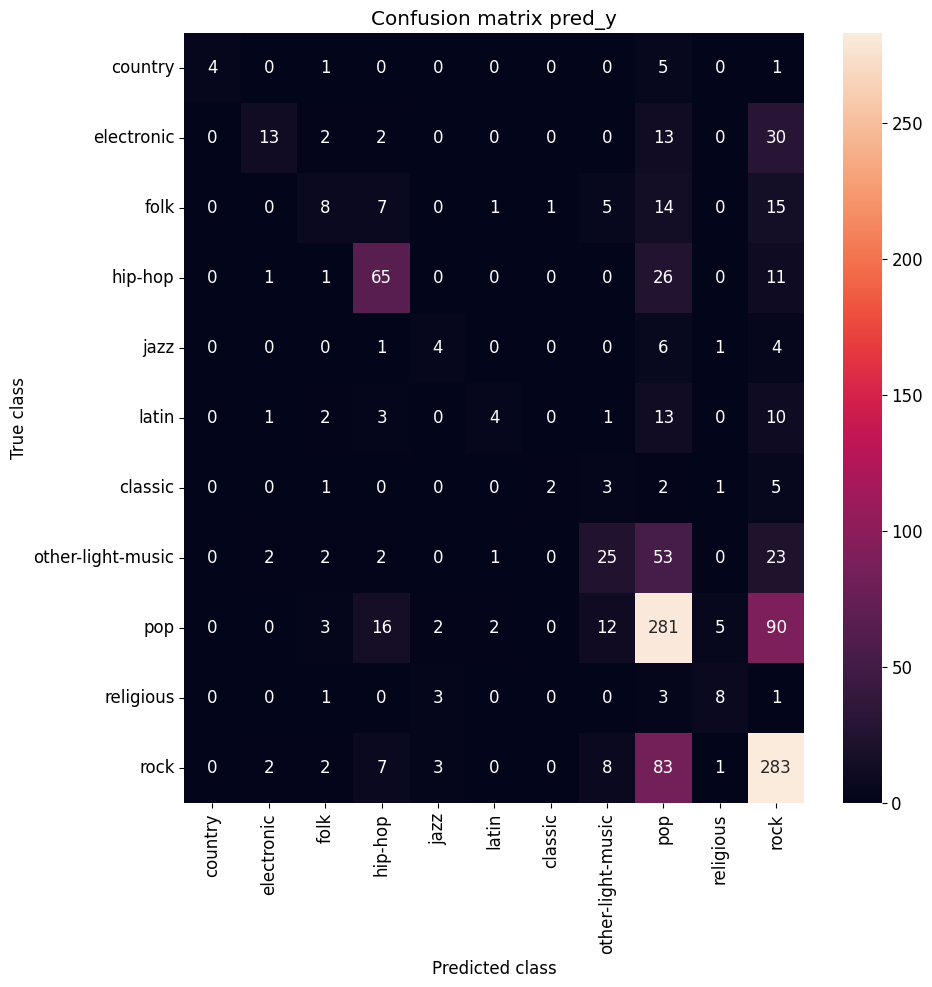

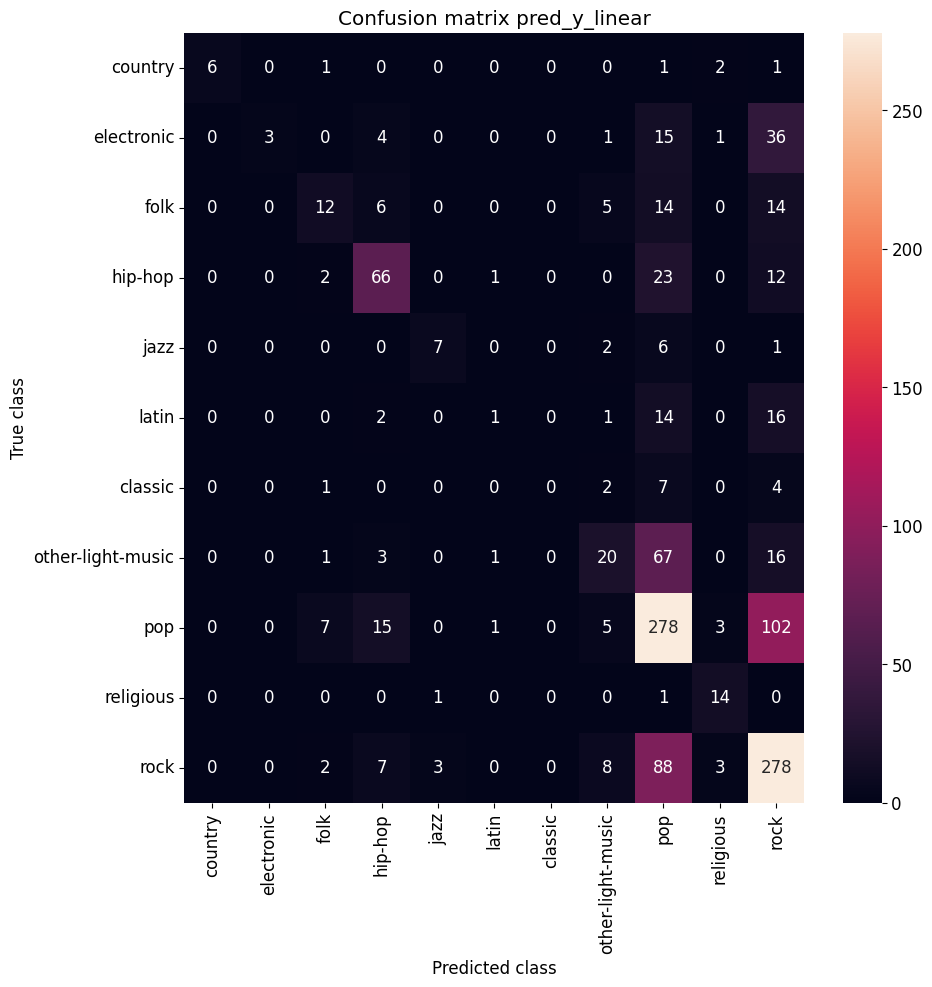

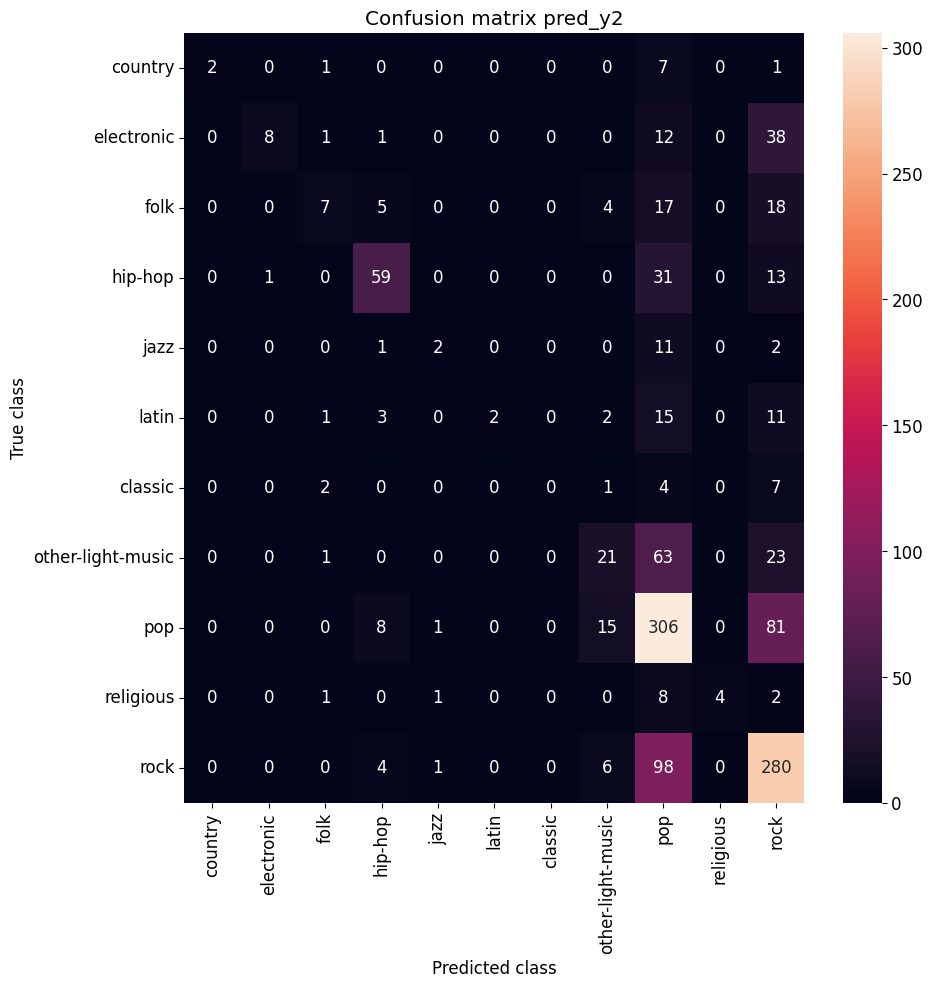

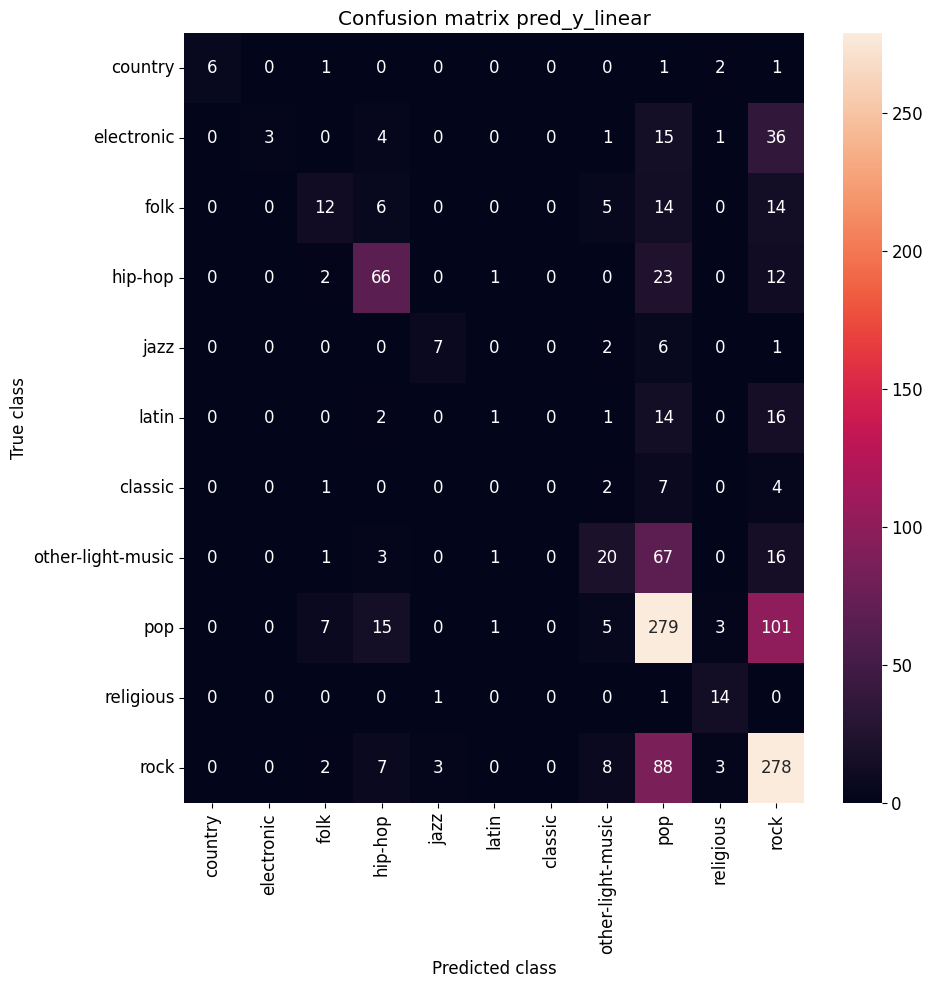

In [80]:
# SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
from sklearn.metrics import f1_score

plt.rcParams["font.size"] = 12

C = 1.
kernel = 'rbf'
gamma  = 0.01

one_rest_f1_final = 0.0
normal_f1_final = 0.0
one_rest_f1_linear_final = 0.0
normal_f1_linear_final = 0.0
for C in [0.1, 1, 10]:
   for ganmma in [0.1, 1, 10]:
      # RBF
      # One-versus-the-restによる分類
      estimator = SVC(C=C, kernel=kernel, gamma=ganmma)
      classifier = multiclass.OneVsRestClassifier(estimator)
      classifier.fit(X_train, y_train)
      pred_y = classifier.predict(X_valid)
      # print("pred_y {}".format(pred_y))
      one_rest_f1 = f1_score(y_valid, pred_y, average="micro")
      print('One-versus-the-rest: {:.5f}'.format(one_rest_f1))
      if one_rest_f1 > one_rest_f1_final:
         pred_y_final = pred_y
         print("ganmma: {}, C: {}".format(ganmma, C))
         one_rest_f1_final = one_rest_f1

      # one-versus-the-oneによる識別（デフォルト）
      classifier2 = SVC(C=C, kernel=kernel, gamma=ganmma)
      classifier2.fit(X_train, y_train)
      pred_y2 = classifier2.predict(X_valid)
      # print("pred_y2 {}".format(pred_y2))
      normal_f1 = f1_score(y_valid, pred_y2, average="micro")
      print('One-versus-one: {:.5f}'.format(normal_f1))
      if normal_f1 > normal_f1_final:
         pred_y2_final = pred_y2
         print("ganmma: {}, C: {}".format(ganmma, C))
         normal_f1_final = normal_f1

      # Linear
      # One-versus-the-restによる分類
      estimator = LinearSVC(C=C)
      classifier = multiclass.OneVsRestClassifier(estimator)
      classifier.fit(X_train, y_train)
      pred_y_linear = classifier.predict(X_valid)
      # print("pred_y_linear {}".format(pred_y_linear))
      one_rest_f1_linear = f1_score(y_valid, pred_y_linear, average="micro")
      print('One-versus-the-rest: {:.5f}'.format(one_rest_f1))
      if one_rest_f1_linear > one_rest_f1_linear_final:
         pred_y_final_linear = pred_y_linear
         print("ganmma: {}, C: {}".format(ganmma, C))
         one_rest_f1_linear_final = one_rest_f1_linear

      # one-versus-the-oneによる識別（デフォルト）
      classifier2 = LinearSVC(C=C)
      classifier2.fit(X_train, y_train)
      pred_y2_linear = classifier2.predict(X_valid)
      # print("pred_y2_linear {}".format(pred_y2_linear))
      normal_f1_linear = f1_score(y_valid, pred_y2_linear, average="micro")
      print('One-versus-one: {:.5f}'.format(normal_f1_linear))
      if normal_f1_linear > normal_f1_linear_final:
         pred_y2_final_linear = pred_y2_linear
         print("ganmma: {}, C: {}".format(ganmma, C))  
         normal_f1_linear_final = normal_f1_linear

# 4つのモデル比較のため、ベストf1を出力する。
print("one_rest_f1_final: {}".format(one_rest_f1_final))
print("normal_f1_final: {}".format(normal_f1_final))
print("one_rest_f1_linear_final: {}".format(one_rest_f1_linear_final))
print("normal_f1_linear_final: {}".format(normal_f1_linear_final))

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, pred_y_final)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix pred_y")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig(filename)
plt.show()

conf_matrix = confusion_matrix(y_valid, pred_y_final_linear)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix pred_y_linear")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig(filename)
plt.show()

conf_matrix = confusion_matrix(y_valid, pred_y2_final)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix pred_y2")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig(filename)
plt.show()

conf_matrix = confusion_matrix(y_valid, pred_y2_final_linear)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix pred_y_linear")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig(filename)
plt.show()


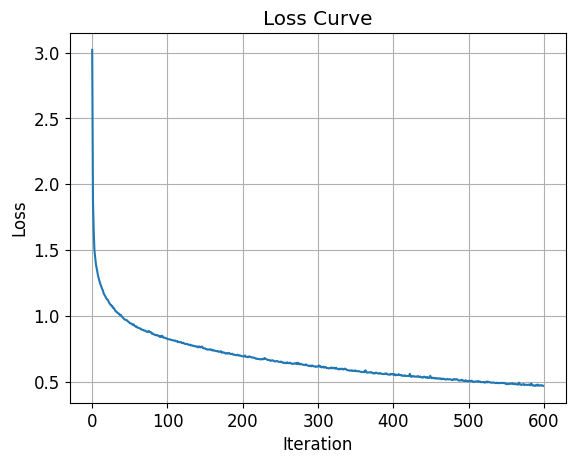

             0         1             2             3             4    
0  3.571994e-14  0.013399  2.564450e-02  7.018036e-02  3.041691e-14  \
1  4.513802e-17  0.034098  1.098552e-02  8.172414e-04  5.578593e-09   
2  5.965375e-17  0.000016  7.902142e-03  3.716690e-11  4.755866e-35   
3  9.460959e-15  0.000018  4.753196e-07  9.983792e-01  6.044937e-19   
4  2.829978e-16  0.000485  8.693650e-04  4.874342e-04  3.305631e-06   

             5             6             7             8             9    
0  2.115398e-01  4.625146e-07  2.293864e-01  8.506602e-02  1.818078e-27  \
1  9.404797e-05  3.575812e-02  7.872095e-03  8.513528e-01  1.637438e-30   
2  4.726631e-14  7.101193e-15  7.956913e-15  1.075999e-05  1.945081e-40   
3  1.457715e-03  1.018285e-10  2.371198e-08  1.144000e-04  6.141222e-25   
4  1.405170e-05  4.918408e-05  9.820689e-01  1.086315e-07  3.977417e-16   

         10  
0  0.364784  
1  0.059022  
2  0.992071  
3  0.000030  
4  0.016023  
MLPClassifier: 0.60379


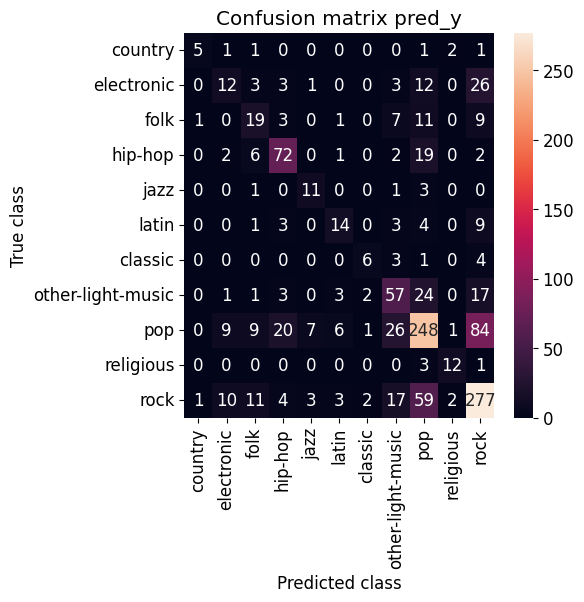

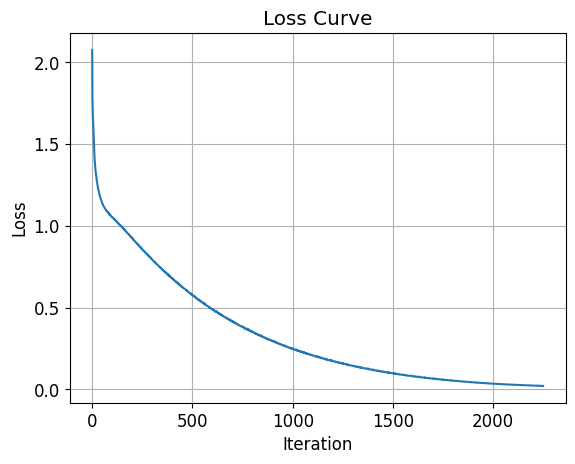

             0             1             2             3             4    
0  1.854624e-12  6.716363e-08  9.008925e-05  2.161996e-06  5.493110e-12  \
1  3.613426e-16  1.079986e-06  3.214981e-05  1.018627e-09  1.039964e-14   
2  3.424848e-18  1.778456e-10  6.797035e-13  3.456520e-22  1.315267e-24   
3  2.031108e-15  4.833130e-14  2.264997e-06  9.999977e-01  5.738946e-20   
4  4.396867e-10  2.495114e-03  5.648593e-03  2.544764e-03  5.315381e-08   

             5             6             7             8             9    
0  2.034873e-01  8.274518e-09  3.360862e-03  7.617850e-01  4.452260e-24  \
1  8.711832e-07  1.888668e-09  1.801834e-06  9.999588e-01  7.654005e-25   
2  3.699093e-22  6.540204e-19  2.648152e-14  4.699368e-15  1.036299e-39   
3  4.265984e-09  6.516256e-16  1.198795e-10  1.066094e-08  8.187639e-26   
4  7.671324e-04  2.449223e-09  3.933254e-01  2.395668e-06  3.006691e-20   

             10  
0  3.127458e-02  
1  5.261307e-06  
2  1.000000e+00  
3  4.831152e-09  
4  5.952

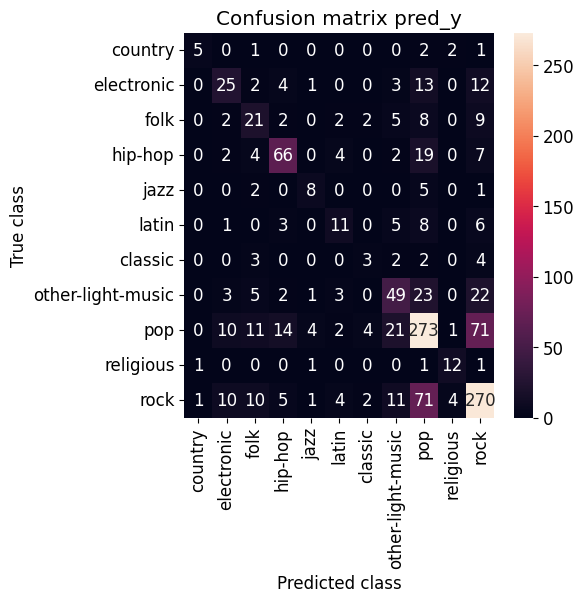

In [81]:
from sklearn.neural_network import MLPClassifier
# SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass

clf = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
clf.fit(X_train, y_train)

pred_y = clf.predict(X_valid)

%matplotlib inline
import matplotlib.pyplot as plt
plt.title("Loss Curve")
plt.plot(clf.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

# 自信を算出
print(pd.DataFrame(clf.predict_proba(X_valid)).head())
# print("pred_y {}".format(pred_y))
mlp_f1 = f1_score(y_valid, pred_y, average="micro")
print('MLPClassifier: {:.5f}'.format(mlp_f1))

conf_matrix = confusion_matrix(y_valid, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix pred_y")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig(filename)
plt.show()
# https://qiita.com/maskot1977/items/d0253e1eab1ff1315dff

clf = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
clf.fit(X_train, y_train)

pred_y = clf.predict(X_valid)

%matplotlib inline
import matplotlib.pyplot as plt
plt.title("Loss Curve")
plt.plot(clf.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

# 自信を算出
print(pd.DataFrame(clf.predict_proba(X_valid)).head())
# print("pred_y {}".format(pred_y))
mlp_f1 = f1_score(y_valid, pred_y, average="micro")
print('MLPClassifier: {:.5f}'.format(mlp_f1))

conf_matrix = confusion_matrix(y_valid, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix pred_y")
plt.ylabel('True class')
plt.xlabel('Predicted class')
# plt.savefig(filename)
plt.show()




In [82]:
y_pred_mlp = clf.predict_proba(test_total)
y_pred_mlp = pd.DataFrame(y_pred_mlp)
set_axis = [str(i) for i in range(0,11,1)]
print(set_axis)
print(y_pred_mlp.columns)
y_pred_mlp = y_pred_mlp.set_axis(set_axis,axis=1)
print(type(y_pred_mlp))
y_pred_mlp = y_pred_mlp.idxmax(axis=1)
print(y_pred_mlp)

# make submission file
submission_pd = pd.concat([test_id, y_pred_mlp], axis=1)
submission_pd.head()
submission_pd.to_csv("submission_MLP.csv", index = False, header = False)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
RangeIndex(start=0, stop=11, step=1)
<class 'pandas.core.frame.DataFrame'>
0        7
1       10
2       10
3       10
4        8
        ..
4041    10
4042     8
4043    10
4044     8
4045     6
Length: 4046, dtype: object


In [83]:
# 計算に2〜３分かかります。
results = []
for hidden_layer_sizes in [10, 100, 1000]:
    for solver in ['adam']:
        for activation in ['identity', 'logistic', 'tanh', 'relu']:
            for learning_rate_init in [0.1, 0.01, 0.001]:
                clf = MLPClassifier(max_iter=10000,
                       hidden_layer_sizes=(hidden_layer_sizes,), 
                       activation=activation, solver=solver,
                       learning_rate_init=learning_rate_init)
                clf.fit(X_train, y_train)
                pred_y = clf.predict(X_valid)
                # score = clf.score(X_train, y_train)
                score = f1_score(y_valid, pred_y, average="micro")
                results.append([hidden_layer_sizes, activation,
                       solver, learning_rate_init, score])
pd.DataFrame([dat for dat in sorted(results, key=lambda f: f[4],
            reverse=True)], columns=["hidden_layer_sizes", 
            "activation", "solver", "learning_rate_init", "score"])

,hidden_layer_sizes,activation,solver,learning_rate_init,score
0,10,logistic,adam,0.010,0.633443
1,1000,tanh,adam,0.001,0.629325
2,100,relu,adam,0.001,0.628501
3,1000,relu,adam,0.001,0.626030
4,1000,tanh,adam,0.010,0.623558
5,10,tanh,adam,0.001,0.614498
6,100,logistic,adam,0.001,0.612026
7,1000,logistic,adam,0.010,0.610379
8,1000,logistic,adam,0.001,0.610379
9,10,logistic,adam,0.001,0.607084


In [84]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

In [85]:
# ## グリッドサーチ
# import lightgbm as lgb

# # https://pythonandai.com/grid-search/
# from sklearn.model_selection import GridSearchCV
# learning_rate = [0.001]
# num_leaves = [31]
# max_depth = [12]
# min_data_in_leaf = [20]
# params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     # 'metric': 'rmse',
#     'metric': ['binary_logloss',"auc"],
#     # 'metric': 'auc', # AUCでもいい
    
#     # "seed":[31],
#     # 'random_state': [42],
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # 'verbose' : [-1],
#     "num_iterations":[10000], # early stopping で止まるため大きめに設定しておけばよい
    
#     # 以下のパラメータを調整対象とする
#     "learning_rate": learning_rate, #学習率
#     "num_leaves":num_leaves,
#     "max_depth":max_depth,
#     "min_data_in_leaf":min_data_in_leaf,
#     # "bagging_fraction":[0.8],
#     # "bagging_freq":[1],
# }

# lgbm = lgb.LGBMClassifier(random_state=0)
# gcv = GridSearchCV(lgbm, params, cv=3, scoring='precision', return_train_score=True)
# gcv.fit(X_train, y_train)

In [86]:
# # グリッドサーチの結果から、学習データとテストデータのスコアを取得
# train_score = gcv.cv_results_["mean_train_score"]
# test_score = gcv.cv_results_["mean_test_score"]

# # matplotlib.pyplotを省略名pltとしてインポート 
# import matplotlib.pyplot as plt
# plt.rcParams["font.size"] = 14

# # 学習データのスコアをプロット
# plt.plot(num_leaves, train_score, label="train_score")

# # テストデータのスコアをプロット
# plt.plot(num_leaves, test_score, label="test_score")

# # グラフにタイトルを追加
# plt.title('train_score vs test_score')

# # グラフのx軸に名前を追加
# plt.xlabel('learning_rate')

# # グラフのy軸に名前を追加
# plt.ylabel('precision')

# # 凡例の表示
# plt.legend()

# # グラフの表示
# plt.show()

In [87]:
# # グリッドサーチの結果から、最適なパラメータを表示
# print("Best parameters: ", gcv.best_params_)

# # 最適なパラメータで学習したモデルを取得
# optimal_model = gcv.best_estimator_

# # 最適なモデルを用いて、評価用データの予測を行う
# predicted_values = optimal_model.predict_proba(test_total)[:,1]


In [88]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

# finish

In [89]:
# 上の方法だとうまく重みづけ学習できないので、別ページを参考に実践する
# https://an-engineer-note.com/?p=312#toc3
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
# dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
# dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？

In [90]:
learning_rate = 0.01
num_leaves = 8
max_depth = 3
min_data_in_leaf = 3
metric = "multi_logloss"
params = {
    'boosting_type': 'gbdt',
    'num_class': 11, # クラスの数
    'objective': 'multiclass',
    'metric': metric,
    # 'metric': 'binary_logloss',
    # 'metric': 'auc', # AUCでもいい
    
    # "seed":31,
    # 'random_state': 42,
    # 'lambda_l2':1, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    "bagging_fraction":0.9,
    "bagging_freq":5,
    "feature_fraction":0.7,
}

In [91]:

#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
               #   categorical_feature = cat_cols, #ここでcategorical_featureを設定
                callbacks=[lgb.early_stopping(stopping_rounds=50, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 2832, number of used features: 73
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive g

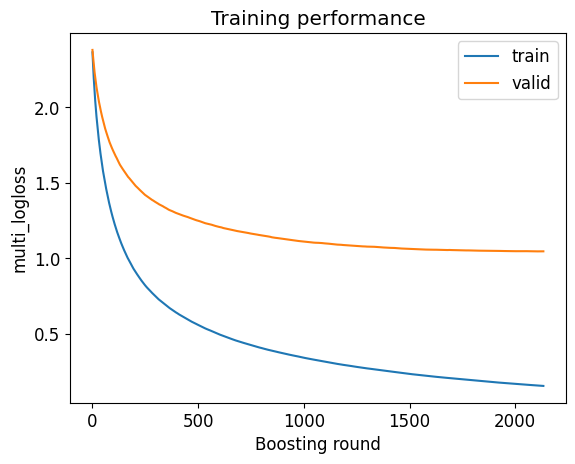

In [92]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train'][metric], label='train')
plt.plot(evaluation_results['valid'][metric], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [93]:
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)


In [94]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

             0         1         2         3             4         5    
0  8.796603e-06  0.020465  0.024027  0.122659  6.237328e-07  0.440087  \
1  1.571336e-06  0.622366  0.000377  0.002672  4.969535e-07  0.009638   
2  3.704218e-06  0.001712  0.001891  0.000007  2.637336e-09  0.000006   
3  1.704742e-05  0.000235  0.006167  0.980767  7.574199e-07  0.004418   
4  5.833047e-07  0.019526  0.136251  0.011460  8.597486e-05  0.002908   

         6         7         8             9         10  
0  0.000226  0.105799  0.136550  1.350446e-07  0.150178  
1  0.002296  0.022312  0.138400  3.150505e-06  0.201933  
2  0.000002  0.000036  0.000654  1.034441e-09  0.995688  
3  0.000013  0.000949  0.006359  1.487784e-08  0.001073  
4  0.002934  0.743913  0.020636  1.272919e-06  0.062285  
0       8.796603e-06
1       1.571336e-06
2       3.704218e-06
3       1.704742e-05
4       5.833047e-07
            ...     
1209    7.198196e-06
1210    2.580672e-06
1211    2.173480e-05
1212    4.408578e-05
121

In [95]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0        5
1        1
2       10
3        3
4        7
        ..
1209     8
1210    10
1211     5
1212     2
1213     7
Length: 1214, dtype: int64

In [96]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(11)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)


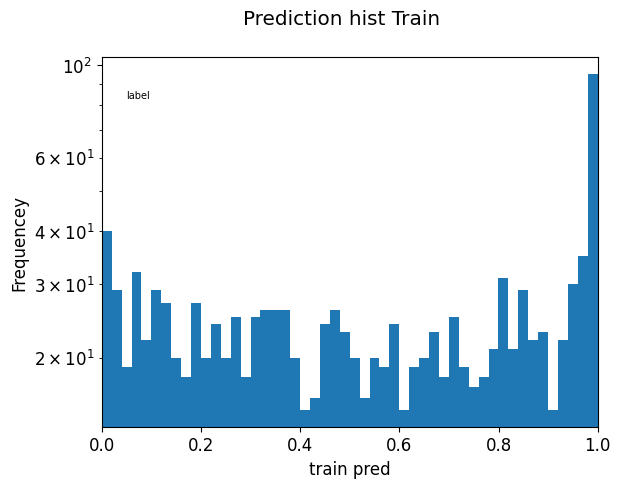

In [97]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

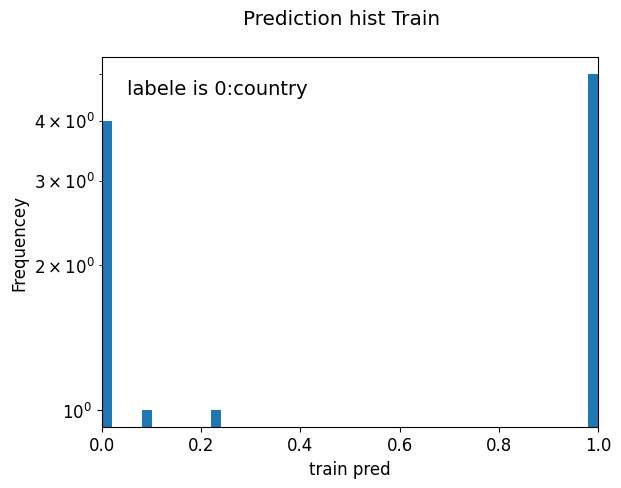

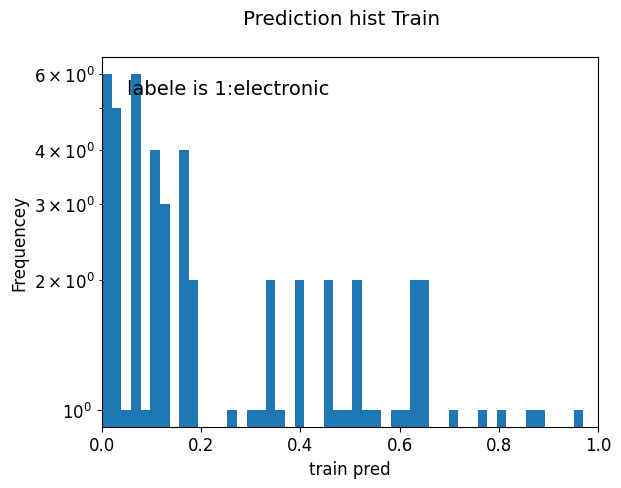

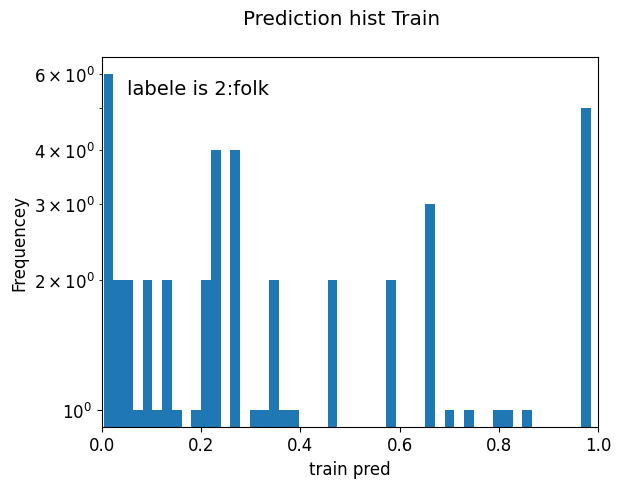

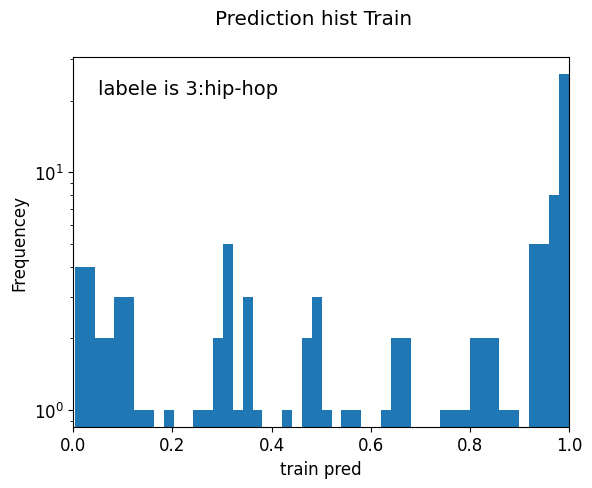

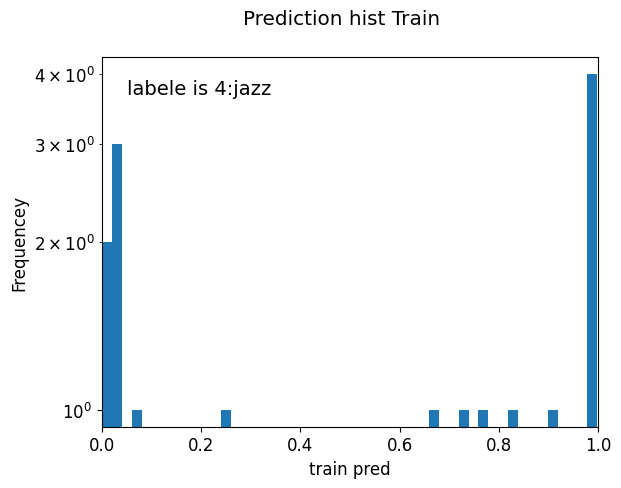

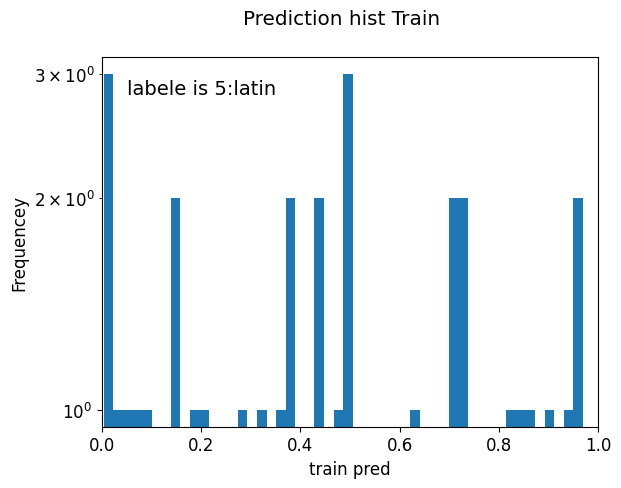

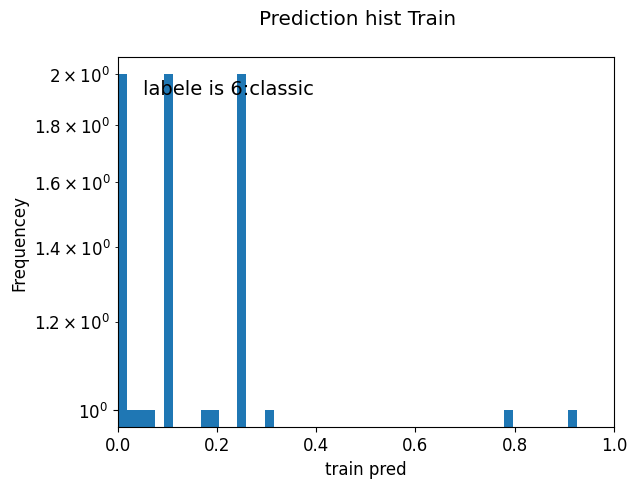

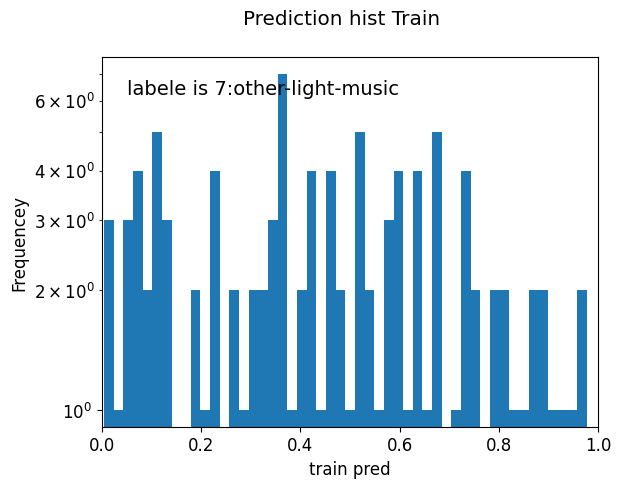

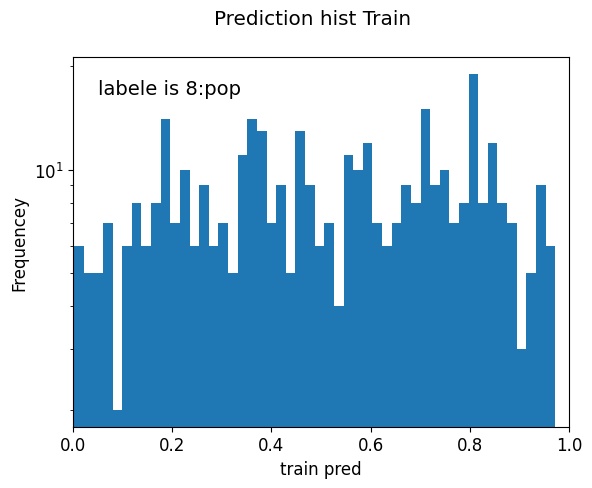

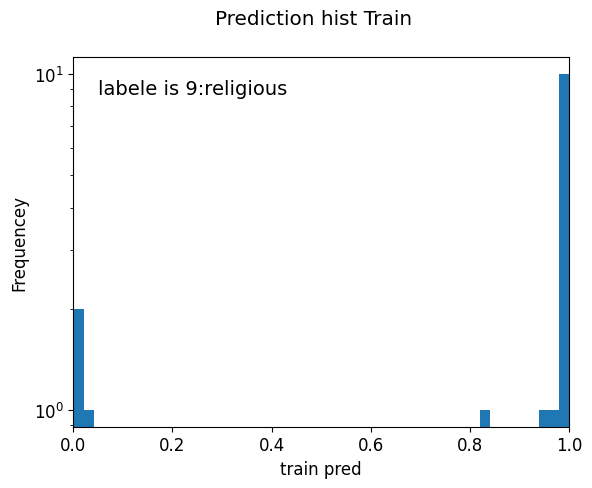

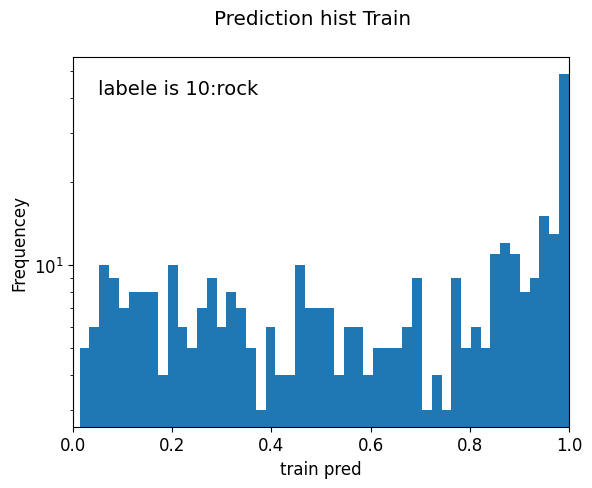

In [98]:
for i, y_pred_category in enumerate(y_pred_categorical):
    f, (ax) = plt.subplots()
    f.suptitle('Prediction hist Train')

    bins = 50

    ax.hist(y_pred_category, bins = bins)

    plt.xlabel('train pred')
    plt.ylabel('Frequencey')
    plt.xlim((0, 1))
    plt.yscale('log')
    plt.text(0.05, 0.9, 'labele is {}:{}'.format(i,genre_data["genre"][i]),transform = ax.transAxes, fontsize = 14)
    plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

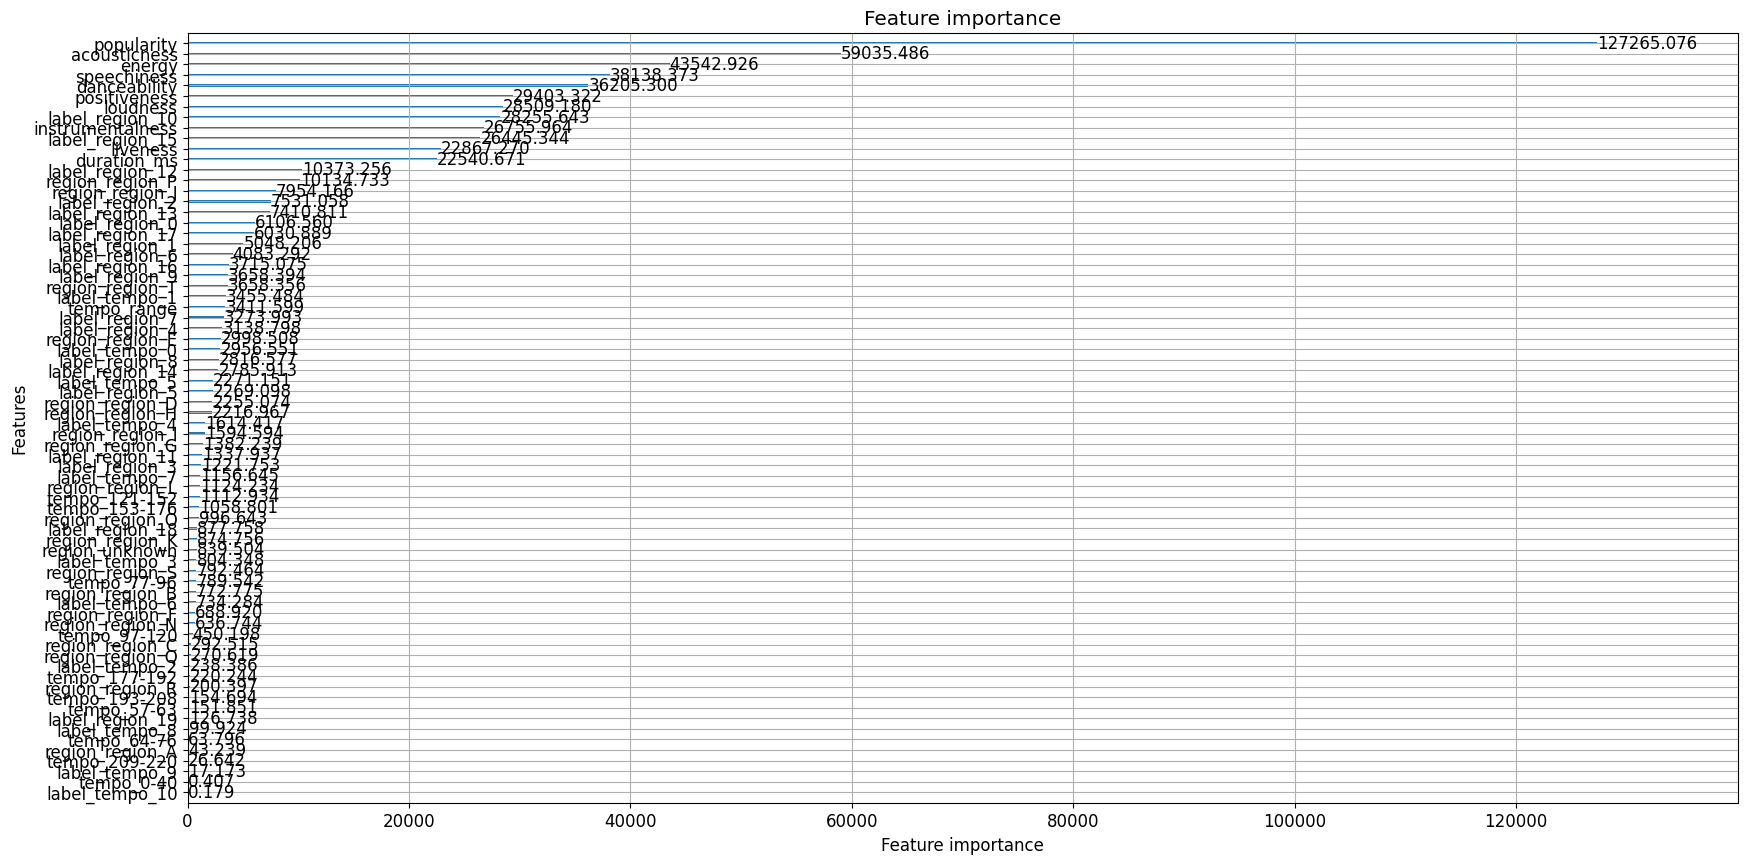

In [99]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

In [100]:
# ROCは２値分類からの変化点があるので一旦コメントアウトして進める。

# from sklearn import metrics
# import matplotlib.pyplot as plt
# fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_train)
# auc = metrics.auc(fpr, tpr)
# print(auc)

# plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
# plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

# plt.legend()
# plt.title('ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.show()


f1_score=0.6293245469522241


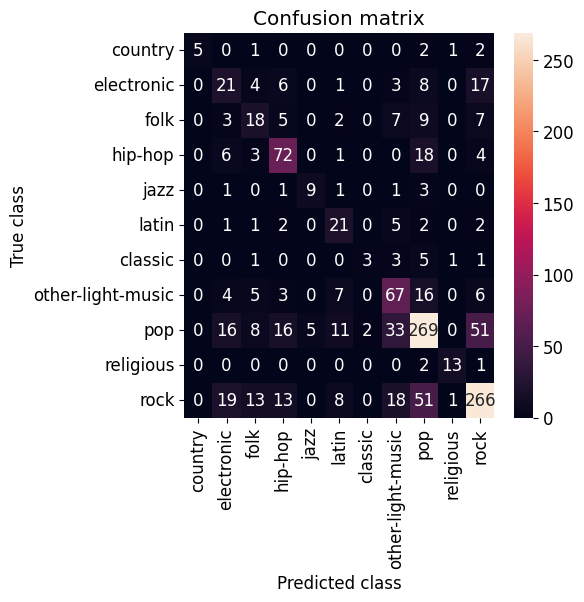

In [101]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


In [102]:
# PRカーブも２値分類からの変化点があるので一旦コメントアウト

# # y_pred = gbm.predict(test_total)
# y_pred = pd.DataFrame(y_pred)
# precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_pred_train)

# auc = metrics.auc(recall, precision)
# print(auc)

# plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
# plt.legend()
# plt.title('PR curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.grid(True)
# plt.show()

In [103]:
# # ROC曲線を計算
# fpr, tpr, thresholds = roc_curve(y_valid, y_pred_train)
 
# # AUCを計算
# roc_auc = metrics.auc(fpr, tpr)
 
# # ROC曲線をプロット
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [104]:
test_id.head()

0    4046
1    4047
2    4048
3    4049
4    4050
Name: index, dtype: int64

In [105]:
# make submission file
submission_pd = pd.concat([test_id, y_pred_submit], axis=1)
submission_pd.head()
submission_pd.to_csv("submission_lightGBM.csv", index = False, header = False)


f1_score=0.6054365733113674


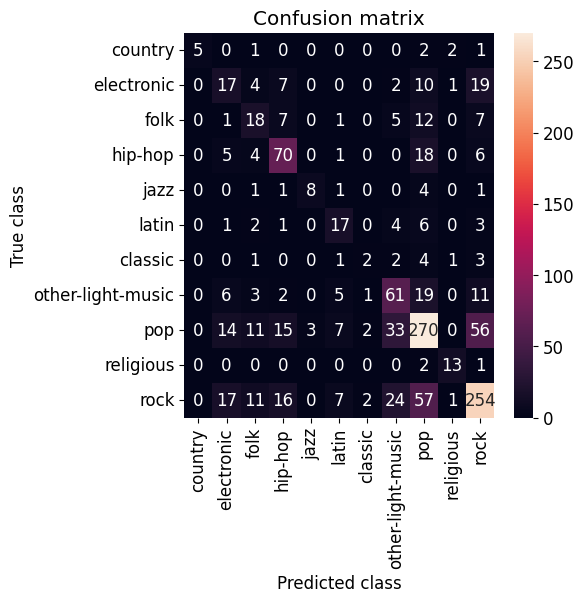

In [ ]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

# make submission file
submission_pd = pd.concat([test_id, y_pred_int], axis=1)
submission_pd.head()
submission_pd.to_csv("submission_ansamble.csv", index = False, header = False)